In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 

In [3]:
##import csv 

In [4]:
survival = pd.read_csv('../../grenenet_cleaning/grenenet/SURVIVAL_total_flowers_collected.csv')

In [5]:
climate = pd.read_csv('../key_files/bioclimvars_experimental_sites_era5.csv')[['site', 'bio1']]

In [6]:
parallelism = pd.read_csv('../key_files/generation_1_parallelism.txt', sep ='\t')

In [7]:
survival.columns

Index(['site', 'plot', 'comments', '1_flowerstotal', '1_survival',
       '1_comments', '2_flowerstotal', '2_survival', '2_comments',
       '3_flowerstotal', '3_survival', '3_comments', '4_flowerstotal',
       '4_surviva', '4_comments', '5_flowerstotal', '5_survival',
       '5_comments'],
      dtype='object')

In [8]:
survival = survival[['site', 'plot', '1_flowerstotal','2_flowerstotal','3_flowerstotal']]

In [9]:
survival['site_plot'] = survival['site'].astype(str) + '_' + survival['plot'].astype(str)

In [10]:
survival = survival[['site_plot', '1_flowerstotal','2_flowerstotal','3_flowerstotal']]

In [11]:
survival.columns = ['site_plot', 1, 2,3]

In [12]:
survival[1].max()

396.0

In [13]:
survival[2].max()

458.0

In [14]:
survival[3].max()

323.0

In [15]:
#survival = survival.dropna(thresh=3) 

In [16]:
df = survival.set_index('site_plot')

In [17]:
#df = df.head(10)

In [18]:
# Drop rows with more than 1 NaN
df_cleaned = df.dropna(thresh=2)  # thresh=2 keeps rows with at least 2 non-NaN values

# Independent variable (generations)
x = np.array([1, 2, 3])

# Extract site information from the index (e.g., '1_1' -> '1')
df_cleaned['site'] = df_cleaned.index.str.split('_').str[0]

/tmp/ipykernel_147400/2735266357.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['site'] = df_cleaned.index.str.split('_').str[0]


In [19]:
# Group the DataFrame by 'site'
grouped = df_cleaned.groupby('site')

In [20]:
climate['site'] = climate['site'].astype(str)

In [21]:
n_sites = 27

In [22]:
import seaborn as sns

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

In [24]:
x_full = np.array([1, 2, 3])  # Generation values

grouped_sites_with_bio1 = pd.merge(df_cleaned[['site']], climate, on='site').drop_duplicates()

In [25]:


grouped_sites_with_bio1_sorted = grouped_sites_with_bio1.sort_values(by='bio1')

In [26]:
def fit_poly(group_long):

    # Prepare data
    x = group_long['Generation'].values.reshape(-1, 1)
    y = group_long['Population'].values
    # Step 1: Create polynomial features
    poly = PolynomialFeatures(degree=2)  # 2-degree polynomial
    x_poly = poly.fit_transform(x)  # Transform x into polynomial features
    
    # Step 2: Fit the model using LinearRegression (no ridge)
    model = LinearRegression()
    model.fit(x_poly, y)  # Fit the model
    
    # Step 3: Retrieve the coefficients and intercept
    intercept = model.intercept_  # This is the constant (c) term
    coefficients = model.coef_  # Coefficients for the polynomial terms
    # Step 4: Predict values for plotting
    x_fine = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    x_fine_poly = poly.transform(x_fine)  # Transform for polynomial features
    y_fine = model.predict(x_fine_poly)

    return model, x_fine, y_fine

def fit_lr(group_long):
    x = group_long['Generation'].values.reshape(-1, 1)
    y = group_long['Population'].values
    
    model = LinearRegression().fit(x, y)
    x_fine = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    y_fine = model.predict(x_fine)
    return model,x_fine, y_fine


In [27]:
colors = sns.color_palette('coolwarm', n_colors=27)

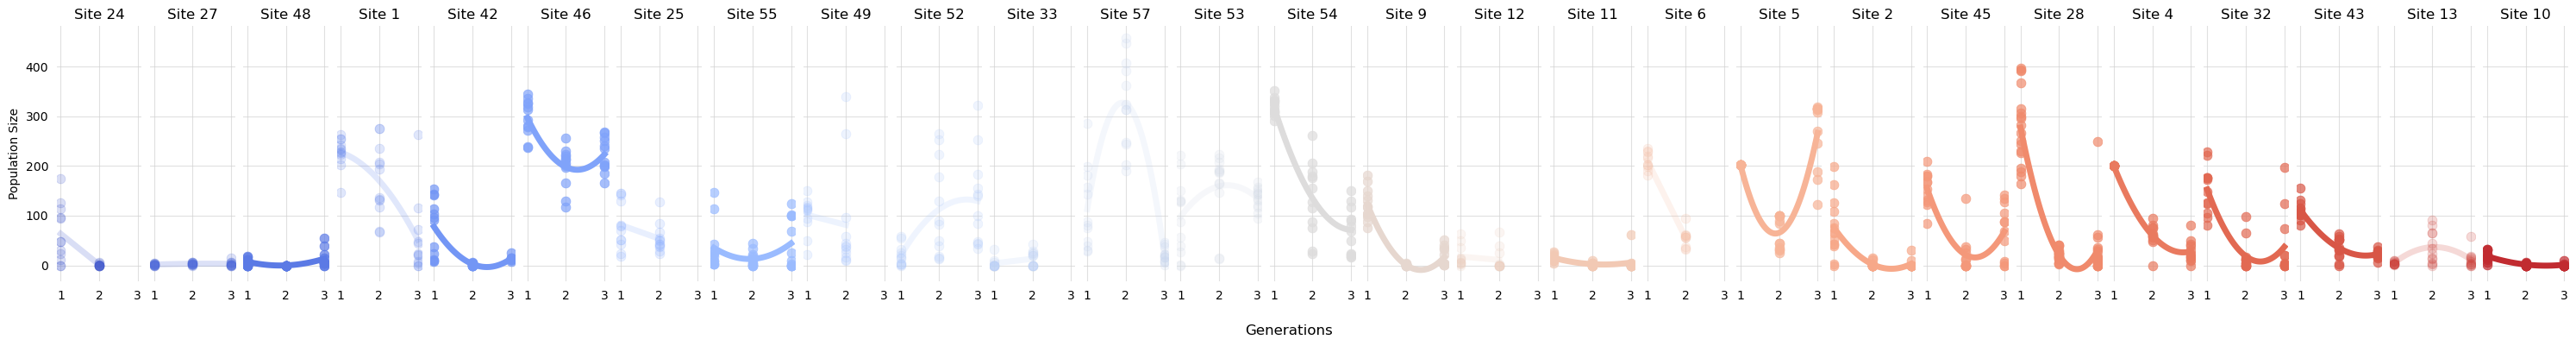

In [28]:
# Set up 3 rows and 9 columns for a total of 27 subplots (adjust to your total sites)

s_size=60
linewidth=5
alpha_scatter = 0.5
n_rows = 1
n_cols = 27
plt.rcParams['axes.axisbelow'] = True
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 4), sharex=True, sharey=True)  # 8x4 per plot, adjust as needed
axes = axes.flatten()  # Flatten the 2D axes array into 1D to easily iterate over

site_min_in_last_gen = {}
coeff_sites = {}
# Loop through each site to plot
for i, site in enumerate(grouped_sites_with_bio1_sorted['site']):
    group = df_cleaned[df_cleaned['site'] == site]

    # Reshape the data from wide to long format
    group_long = group.melt(var_name='Generation', value_name='Population', value_vars=[1, 2, 3], ignore_index=False)

    # Drop NaN values and ensure numeric types
    group_long = group_long.dropna()
    group_long['Generation'] = pd.to_numeric(group_long['Generation'])
    group_long['Population'] = pd.to_numeric(group_long['Population'])

    # Get the correct subplot
    ax = axes[i] if len(axes) > 1 else axes

    if group_long['Generation'].nunique() == 3:
        model, x_fine, y_fine = fit_poly(group_long)
        intercept = model.intercept_  # This is the constant (c) term
        coefficients = model.coef_  #
        coeff_sites[site] = [intercept, coefficients]
        if (coefficients[1]<0) & (coefficients[2] > 0):
            ## evolutioanry rescue 
            sns.scatterplot(data=group_long, x='Generation', y='Population', ax=ax, color=colors[i], alpha =0.7, s = s_size, edgecolor=None,)
        # Plot
            ax.plot(x_fine, y_fine, color=colors[i],linewidth=linewidth)
            #ax.plot(x_fine, y_fine, color='black',linewidth=1.5)
        else:
            sns.scatterplot(data=group_long, x='Generation', y='Population', ax=ax, color=colors[i], alpha =0.2, s = s_size, edgecolor=None,)
        # Plot
            ax.plot(x_fine, y_fine,color=colors[i],linewidth=linewidth, alpha = 0.2)

    elif group_long['Generation'].nunique() < 3:
        model, x_fine, y_fine = fit_lr(group_long)
        intercept = model.intercept_  # This is the constant (c) term
        coefficients = model.coef_  #
        coeff_sites[site] = [intercept, coefficients]
        if (coefficients[0] > 0):
            ## evolutioanry rescue 
            sns.scatterplot(data=group_long, x='Generation', y='Population', ax=ax, color=colors[i], alpha =0.2, s = s_size, edgecolor=None,)
        # Plot
            ax.plot(x_fine, y_fine, color=colors[i],linewidth=linewidth, alpha = 0.2)
        else:
            sns.scatterplot(data=group_long, x='Generation', y='Population', ax=ax,color=colors[i], alpha =0.2, s = s_size, edgecolor=None,)
        # Plot
            ax.plot(x_fine, y_fine, color=colors[i], linewidth=linewidth, alpha = 0.2)


    # Remove spines (top and right)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)  # Also remove the left spine if you want to clean up more
    ax.spines['bottom'].set_visible(False)  # Also remove the bottom spine for a cleaner look
        # Remove ticks for all subplots except the first one

    # Add title and labels for each subplot
    bio1_value = int(grouped_sites_with_bio1_sorted.loc[grouped_sites_with_bio1_sorted["site"] == site, "bio1"].values[0])
    ax.set_title(f'Site {site}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Population Size')
    ax.grid(True, color='lightgrey', alpha=0.7)
    ax.tick_params(axis='x', which='both',bottom=False)
    ax.tick_params(axis='y', which='both', left=False)
    ax.set_xlabel('')
fig.supxlabel('Generations')  # Set a common x-axis label for the entire figure

#plt.savefig('population_dynamics.png')
# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce space between subplots horizontally and vertically
#plt.savefig('pop_dynamics_highlighted_er.png')
#plt.savefig('pop_dynamics_highlighted_er.pdf')

In [29]:
combined_sites_data = {site: [intercept] + coefficients.tolist() for site, (intercept, coefficients) in coeff_sites.items()}

In [30]:
for site, values in combined_sites_data.items():
    if len(values) == 4 and values[1] == 0:  # If it's a length-3 array (intercept + 3 coefficients)
        # Remove the zero in the second position
        combined_sites_data[site] = [values[0]] + values[2:]
    elif len(values) == 2:  # If it's a length-1 array (intercept + 1 coefficient)
        # Add a zero at the end
        combined_sites_data[site] = values + [0]
    else:
        # Keep the values as they are if neither condition applies
        combined_sites_data[site] = values

In [31]:
coeff_sitesdf = pd.DataFrame(combined_sites_data).T.reset_index()

In [32]:
coeff_sitesdf.columns = ['site', 'intercept', 'linear_term', 'cuadratic_term']

In [33]:
coeff_sitesdf = coeff_sitesdf.merge(climate)

In [34]:
parallelism['site'] = parallelism['site'].astype(str)

In [35]:
parallelism_snps = parallelism[parallelism['source'] == 'snp']

parallelism_snps = parallelism_snps[['site', 'mean']]

parallelism_snps.columns = ['site', 'p_snps']

In [36]:
parallelism_ecotypes = parallelism[parallelism['source'] == 'ecotype']

parallelism_ecotypes = parallelism_ecotypes[['site', 'mean']]

parallelism_ecotypes.columns = ['site', 'p_ecotypes']

In [37]:
parallelism_ecotypes.sort_values('p_ecotypes')['site'].values

array(['48', '27', '13', '2', '12', '28', '60', '11', '55', '25', '24',
       '52', '57', '53', '37', '26', '23', '10', '9', '1', '42', '45',
       '46', '6', '49', '54', '43', '4', '5', '32'], dtype=object)

In [38]:
coeff_sitesdf = coeff_sitesdf.merge(parallelism_snps).merge(parallelism_ecotypes)

In [39]:
#coeff_sitesdf.to_csv('../key_files/population_dynamics.csv', index=None)

In [40]:
coeff_sitesdf = coeff_sitesdf[coeff_sitesdf['site']!='57']

In [41]:
coeff_sitesdf = coeff_sitesdf[coeff_sitesdf['cuadratic_term']!=0]

In [42]:
coeff_sitesdf.sort_values('p_ecotypes').site.values

array(['48', '27', '13', '2', '28', '11', '55', '52', '53', '10', '9',
       '1', '42', '45', '46', '54', '43', '4', '5', '32'], dtype=object)

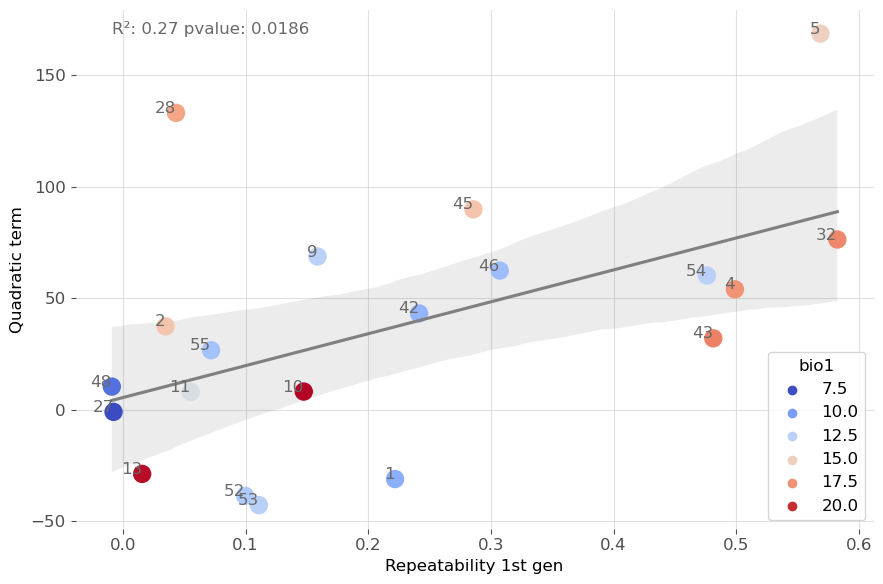

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


font_size = 12
# Assuming coeff_sitesdf is a DataFrame with columns 'site', 'p_ecotypes', 'cuadratic_term'
plt.rcParams['axes.axisbelow'] = True

# Perform linear regression using scipy to get slope, intercept, and R² value
x = coeff_sitesdf['p_ecotypes']
y = coeff_sitesdf['cuadratic_term']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the scatter plot with seaborn
plt.figure(figsize=(9, 6))
sns.regplot(
    data=coeff_sitesdf, 
    x='p_ecotypes', 
    y='cuadratic_term', 
    scatter=False,
    line_kws={'color': 'grey'}  # Color the regression line
)

sns.scatterplot(
    data=coeff_sitesdf, 
    x='p_ecotypes', 
    y='cuadratic_term', 
    hue = 'bio1', 
    palette='coolwarm',
    edgecolor=None,
    s= 150,
)

# Add labels for each site at the corresponding points
for i in range(coeff_sitesdf.shape[0]):
    site = coeff_sitesdf['site'].iloc[i]
    x_value = coeff_sitesdf['p_ecotypes'].iloc[i]
    y_value = coeff_sitesdf['cuadratic_term'].iloc[i]
    plt.text(x_value, y_value, site, fontsize=12, ha='right', color = 'dimgray')  # ha='right' adjusts horizontal alignment

# Display the slope and R² on the plot
plt.text(min(x), max(y), f'R²: {r_value**2:.2f} pvalue: {p_value:.4f}', fontsize=12, color='dimgray')

## labels 
plt.ylabel('Quadratic term')
plt.xlabel('Repeatability 1st gen')

plt.rc('font', family='sans-serif', size=font_size, weight='normal')  # Regular font size
plt.rc('axes', titlesize=font_size, labelsize=font_size)  # Title and label size for axes
plt.rc('xtick', labelsize=font_size)  # X tick labels size
plt.rc('ytick', labelsize=font_size)  # Y tick labels size

dark_grey = '#4D4D4D'  # Define dark grey color

# Apply to spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set tick parameters
plt.tick_params(axis='both', colors=dark_grey)  # Set tick colors
plt.grid(True, color='lightgrey', alpha=0.7)

# Adjust the layout and show the plot
plt.tight_layout()
plt.savefig('parallelism_ecotypes_cuadratic_term_flower_counts.png')
plt.savefig('parallelism_ecotypes_cuadratic_term_flower_counts.pdf')


plt.show()




In [50]:
r_value**2

0.2709626848957606

In [51]:
p_value

0.018619193057357056

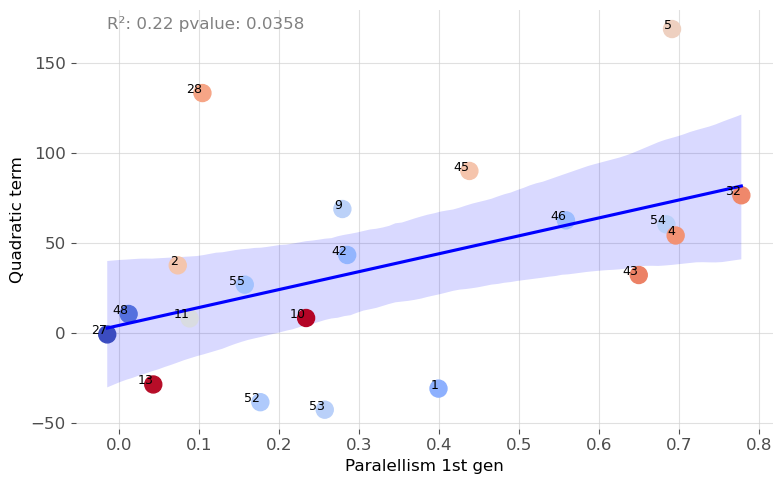

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


font_size = 12
# Assuming coeff_sitesdf is a DataFrame with columns 'site', 'p_ecotypes', 'cuadratic_term'
plt.rcParams['axes.axisbelow'] = True

# Perform linear regression using scipy to get slope, intercept, and R² value
x = coeff_sitesdf['p_snps']
y = coeff_sitesdf['cuadratic_term']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the scatter plot with seaborn
plt.figure(figsize=(8, 5))
sns.regplot(
    data=coeff_sitesdf, 
    x='p_snps', 
    y='cuadratic_term', 
    scatter=False,
    line_kws={'color': 'blue'}  # Color the regression line
)

sns.scatterplot(
    data=coeff_sitesdf, 
    x='p_snps', 
    y='cuadratic_term', 
    hue = 'bio1', 
    palette='coolwarm',
    edgecolor=None,
    s= 150,
    legend=False,
)

# Add labels for each site at the corresponding points
for i in range(coeff_sitesdf.shape[0]):
    site = coeff_sitesdf['site'].iloc[i]
    x_value = coeff_sitesdf['p_snps'].iloc[i]
    y_value = coeff_sitesdf['cuadratic_term'].iloc[i]
    plt.text(x_value, y_value, site, fontsize=9, ha='right')  # ha='right' adjusts horizontal alignment

# Display the slope and R² on the plot
plt.text(min(x), max(y), f'R²: {r_value**2:.2f} pvalue: {p_value:.4f}', fontsize=12, color='grey')

## labels 
plt.ylabel('Quadratic term')
plt.xlabel('Paralellism 1st gen')

plt.rc('font', family='sans-serif', size=font_size, weight='normal')  # Regular font size
plt.rc('axes', titlesize=font_size, labelsize=font_size)  # Title and label size for axes
plt.rc('xtick', labelsize=font_size)  # X tick labels size
plt.rc('ytick', labelsize=font_size)  # Y tick labels size

dark_grey = '#4D4D4D'  # Define dark grey color

# Apply to spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set tick parameters
plt.tick_params(axis='both', colors=dark_grey)  # Set tick colors
plt.grid(True, color='lightgrey', alpha=0.7)

# Adjust the layout and show the plot
plt.tight_layout()
#plt.savefig('parallelism_cuadratic_term.png')

plt.show()




In [42]:
## population size against parallelism 

In [43]:
survival

,site_plot,1,2,3
0,1_1,146.0,208.0,24.0
1,1_2,235.0,194.0,0.0
2,1_3,229.0,117.0,0.0
3,1_4,233.0,235.0,20.0
4,1_5,226.0,204.0,72.0
...,...,...,...,...
424,60_8,24.0,NaN,NaN
425,60_9,7.0,NaN,NaN
426,60_10,21.0,NaN,NaN
427,60_11,20.0,NaN,NaN


In [49]:
pop_size_gen1  = survival[['site_plot', 1]]

NameError: name 'pop_size' is not defined

In [51]:
gen = 3

pop_size_gen1  = survival[['site_plot', gen]]

pop_size_gen1 = pop_size_gen1.dropna()

In [52]:
pop_size_gen1['site']  = pop_size_gen1['site_plot'].str.split('_').str[0]

pop_size_gen1 = pop_size_gen1.groupby('site')[gen].mean().reset_index()

parallelism_wpopsize = parallelism.merge(pop_size_gen1, on = 'site')

parallelism_wpopsize.columns = ['site', 'mean', 'lower', 'upper', 'generation', 'source', 'pop_size']

parallelism_wpopsize = parallelism_wpopsize.merge(climate)

parallelism_wpopsize_snps = parallelism_wpopsize[parallelism_wpopsize['source'] == 'snp']
parallelism_wpopsize_ecotypes = parallelism_wpopsize[parallelism_wpopsize['source'] == 'ecotype']



parallelism_wpopsize_ecotypes.head()

,site,mean,lower,upper,generation,source,pop_size,bio1
1,1,0.221854,0.197582,0.244416,1,ecotype,51.666667,10.743906
3,2,0.034774,-0.011705,0.077576,1,ecotype,2.857143,15.594627
5,4,0.498951,0.478904,0.517680,1,ecotype,28.500000,17.513474
7,5,0.568639,0.527622,0.614460,1,ecotype,266.583333,14.996355
9,9,0.158673,0.126734,0.186057,1,ecotype,16.583333,12.481669


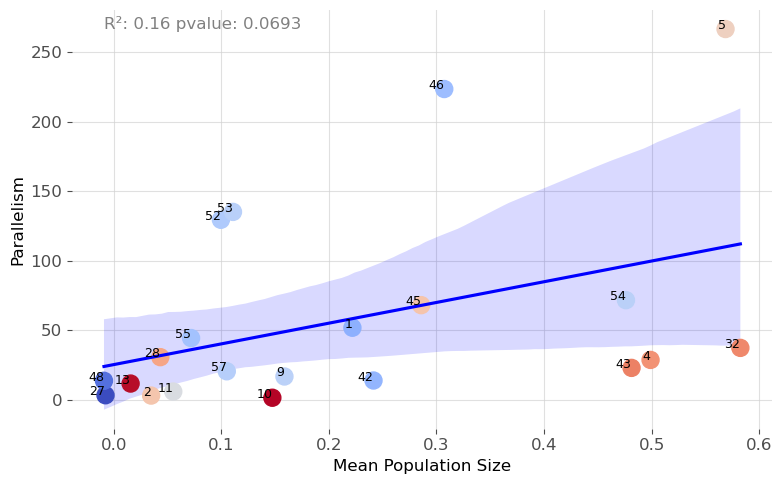

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


font_size = 12
# Assuming coeff_sitesdf is a DataFrame with columns 'site', 'p_ecotypes', 'cuadratic_term'
plt.rcParams['axes.axisbelow'] = True

# Perform linear regression using scipy to get slope, intercept, and R² value
x = parallelism_wpopsize_ecotypes['mean']
y = parallelism_wpopsize_ecotypes['pop_size']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the scatter plot with seaborn
plt.figure(figsize=(8, 5))
sns.regplot(
    data=parallelism_wpopsize_ecotypes, 
    x='mean', 
    y='pop_size', 
    scatter=False,
    line_kws={'color': 'blue'}  # Color the regression line
)

sns.scatterplot(
    data=parallelism_wpopsize_ecotypes, 
    x='mean', 
    y='pop_size', 
    hue = 'bio1', 
    palette='coolwarm',
    edgecolor=None,
    s= 150,
    legend=False,
)

# Add labels for each site at the corresponding points
for i in range(parallelism_wpopsize_ecotypes.shape[0]):
    site = parallelism_wpopsize_ecotypes['site'].iloc[i]
    x_value = parallelism_wpopsize_ecotypes['mean'].iloc[i]
    y_value = parallelism_wpopsize_ecotypes['pop_size'].iloc[i]
    plt.text(x_value, y_value, site, fontsize=9, ha='right')  # ha='right' adjusts horizontal alignment

# Display the slope and R² on the plot
plt.text(min(x), max(y), f'R²: {r_value**2:.2f} pvalue: {p_value:.4f}', fontsize=12, color='grey')

## labels 
plt.ylabel('Parallelism')
plt.xlabel('Mean Population Size')

plt.rc('font', family='sans-serif', size=font_size, weight='normal')  # Regular font size
plt.rc('axes', titlesize=font_size, labelsize=font_size)  # Title and label size for axes
plt.rc('xtick', labelsize=font_size)  # X tick labels size
plt.rc('ytick', labelsize=font_size)  # Y tick labels size

dark_grey = '#4D4D4D'  # Define dark grey color

# Apply to spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set tick parameters
plt.tick_params(axis='both', colors=dark_grey)  # Set tick colors
plt.grid(True, color='lightgrey', alpha=0.7)

# Adjust the layout and show the plot
plt.tight_layout()
#plt.savefig('parallelism_pop_size_fc.png')

plt.show()


